In [1]:
import pandas as pd
import numpy as np
import collections as cl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

from functools import partial

import itertools

%matplotlib inline

In [2]:
#Load original dataset
churn_original = pd.read_excel("Churn_original.xlsx")

In [3]:
churn_original = churn_original[churn_original["TotalCharges"] != " "]
churn_original["TotalCharges"] = churn_original["TotalCharges"].astype(float)

In [4]:
#Load dataset with categorical columns
churn = pd.read_excel("Churn.xlsx")
churn = churn[churn["TotalCharges"] != " "]
churn["TotalCharges"] = churn["TotalCharges"].astype(float)

# Data Preprocessing

In [5]:
sigmaTotalCharges = churn.TotalCharges.std()
sigmaMonthlyCharges = churn.TotalCharges.std()
sigmaTenure = churn.tenure.std()
meanTotalCharges = churn.TotalCharges.mean()
meanMonthlyCharges = churn.MonthlyCharges.mean()
meanTenure = churn.tenure.mean()

In [6]:
churn.TotalCharges = churn.TotalCharges.transform(lambda x: (x - meanTotalCharges) / sigmaTotalCharges)
churn.MonthlyCharges = churn.MonthlyCharges.transform(lambda x: (x - meanMonthlyCharges) / sigmaMonthlyCharges)
churn.tenure = churn.tenure.transform(lambda x: (x - meanTenure) / meanTenure)

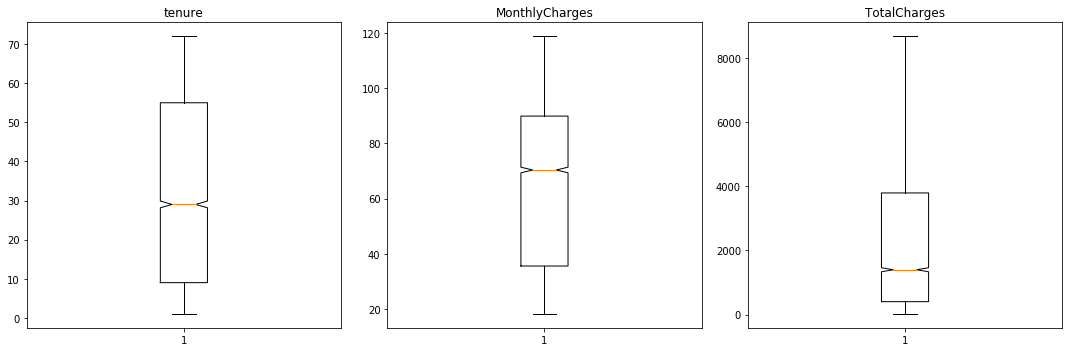

In [7]:
names = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i in range (len(names)):
    column_name = names[i]
    ax[i].set_title(column_name)
    ax[i].boxplot(np.array(churn_original[column_name]), 1, showfliers=True)
plt.tight_layout()

##### Correlations

In [8]:
churn_corr = churn.corr()

corr = []
churn_tmp = churn.copy()
churn_tmp.drop("customerID", axis =1, inplace =  True)
i, j = 0, 0

for c1 in churn.drop("customerID", axis=1).columns:
    churn_tmp.drop(c1, axis =1, inplace =  True)
    for c2 in churn_tmp.columns:
        corr.append([round(churn_corr[c1].loc[c2],4),c1,c2])
        j = j+1
    i = i+1

corr_sorted = sorted(corr, reverse=True)
corr_sorted

[[1.0, 'TechSupportNoService', 'StreamingTVNoService'],
 [1.0, 'TechSupportNoService', 'StreamingMoviesNoService'],
 [1.0, 'StreamingTVNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineSecurityNoService', 'TechSupportNoService'],
 [1.0, 'OnlineSecurityNoService', 'StreamingTVNoService'],
 [1.0, 'OnlineSecurityNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineSecurityNoService', 'OnlineBackupNoService'],
 [1.0, 'OnlineSecurityNoService', 'DeviceProtectionnoService'],
 [1.0, 'OnlineBackupNoService', 'TechSupportNoService'],
 [1.0, 'OnlineBackupNoService', 'StreamingTVNoService'],
 [1.0, 'OnlineBackupNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineBackupNoService', 'DeviceProtectionnoService'],
 [1.0, 'InternetServiceNo', 'TechSupportNoService'],
 [1.0, 'InternetServiceNo', 'StreamingTVNoService'],
 [1.0, 'InternetServiceNo', 'StreamingMoviesNoService'],
 [1.0, 'InternetServiceNo', 'OnlineSecurityNoService'],
 [1.0, 'InternetServiceNo', 'OnlineBackupNoService'],
 [1.0, 'I

*We observe that all the columns "No service" contain redundant information. Indeed, the columns with values "no Internet values" are equal to the column "Internet service". That's the same for the columns "Multiple lines" and "Phone service".
Thus, we can delete the columns 'TechSupportNoService', 'StreamingTVNoService', 'StreamingMoviesNoService', 'OnlineSecurityNoService', 'OnlineBackupNoService', 'DeviceProtectionnoService' and 'MultipleLinesNoService'*

In [9]:
#Deletion of redundant columns
churn.drop(['TechSupportNoService', 'StreamingTVNoService', 'StreamingMoviesNoService', 'OnlineSecurityNoService', 'OnlineBackupNoService', 'DeviceProtectionnoService', 'MultipleLinesNoService'], axis=1, inplace=True)

In [10]:
churn_corr = churn.corr()

corr = []
churn_tmp = churn.copy()
churn_tmp.drop("customerID", axis =1, inplace =  True)
i, j = 0, 0

for c1 in churn.drop("customerID", axis=1).columns:
    churn_tmp.drop(c1, axis =1, inplace =  True)
    for c2 in churn_tmp.columns:
        corr.append([round(churn_corr[c1].loc[c2],4),c1,c2])
        j = j+1
    i = i+1

corr_sorted = sorted(corr, reverse=True)
corr_sorted

[[0.8259, 'tenure', 'TotalCharges'],
 [0.7872, 'InternetServiceFiber', 'MonthlyCharges'],
 [0.6511, 'MonthlyCharges', 'TotalCharges'],
 [0.6297, 'StreamingTVYes', 'MonthlyCharges'],
 [0.6272, 'StreamingMoviesYes', 'MonthlyCharges'],
 [0.5638, 'tenure', 'ContractTwoYear'],
 [0.5381, 'StreamingTVNo', 'StreamingMoviesNo'],
 [0.5334, 'StreamingTVYes', 'StreamingMoviesYes'],
 [0.5229, 'DeviceProtectionYes', 'TotalCharges'],
 [0.5199, 'StreamingMoviesYes', 'TotalCharges'],
 [0.5157, 'StreamingTVYes', 'TotalCharges'],
 [0.5101, 'OnlineBackupYes', 'TotalCharges'],
 [0.4909, 'MultipleLinesYes', 'MonthlyCharges'],
 [0.4826, 'DeviceProtectionYes', 'MonthlyCharges'],
 [0.4701, 'OnlineSecurityNo', 'TechSupportNo'],
 [0.469, 'MultipleLinesYes', 'TotalCharges'],
 [0.4523, 'Partner', 'Dependents'],
 [0.4415, 'OnlineBackupYes', 'MonthlyCharges'],
 [0.4385, 'TechSupportNo', 'ContractMonth'],
 [0.4329, 'TechSupportYes', 'TotalCharges'],
 [0.4297, 'DeviceProtectionNo', 'StreamingMoviesNo'],
 [0.42, 'Devic

##### Note about charges

In [11]:
print(churn.tenure.multiply(churn.MonthlyCharges).corr(churn.TotalCharges))

0.4266703976563019


*We observe that the column "Total Charges" is almost equal to the multiplication of the columns "Monthly Charges" and "Tenure". So we have also redundant information with those 3 columns.*

# Observation of the values in the dataset

In [12]:
for column_name in churn_original.drop("tenure", axis=1).columns[1:-3]:
    print(churn_original[str(column_name)].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('\r')

Male      3549
Female    3483
Name: gender, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

0    5890
1    1142
Name: SeniorCitizen, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No     3639
Yes    3393
Name: Partner, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No     4933
Yes    2099
Name: Dependents, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Yes    6352
No      680
Name: PhoneService, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No                     3087
Yes                    2425
No internet service    15

# First analysis of the importance of features

### Analysis of categorical variables

In this part, we display in histograms the proportion of clients who churned for each feature. That will give us a first estimation of the importance of each feature.

Proportion of churns for each feature: (the light gray aera is the proportion of people who didn't churn)


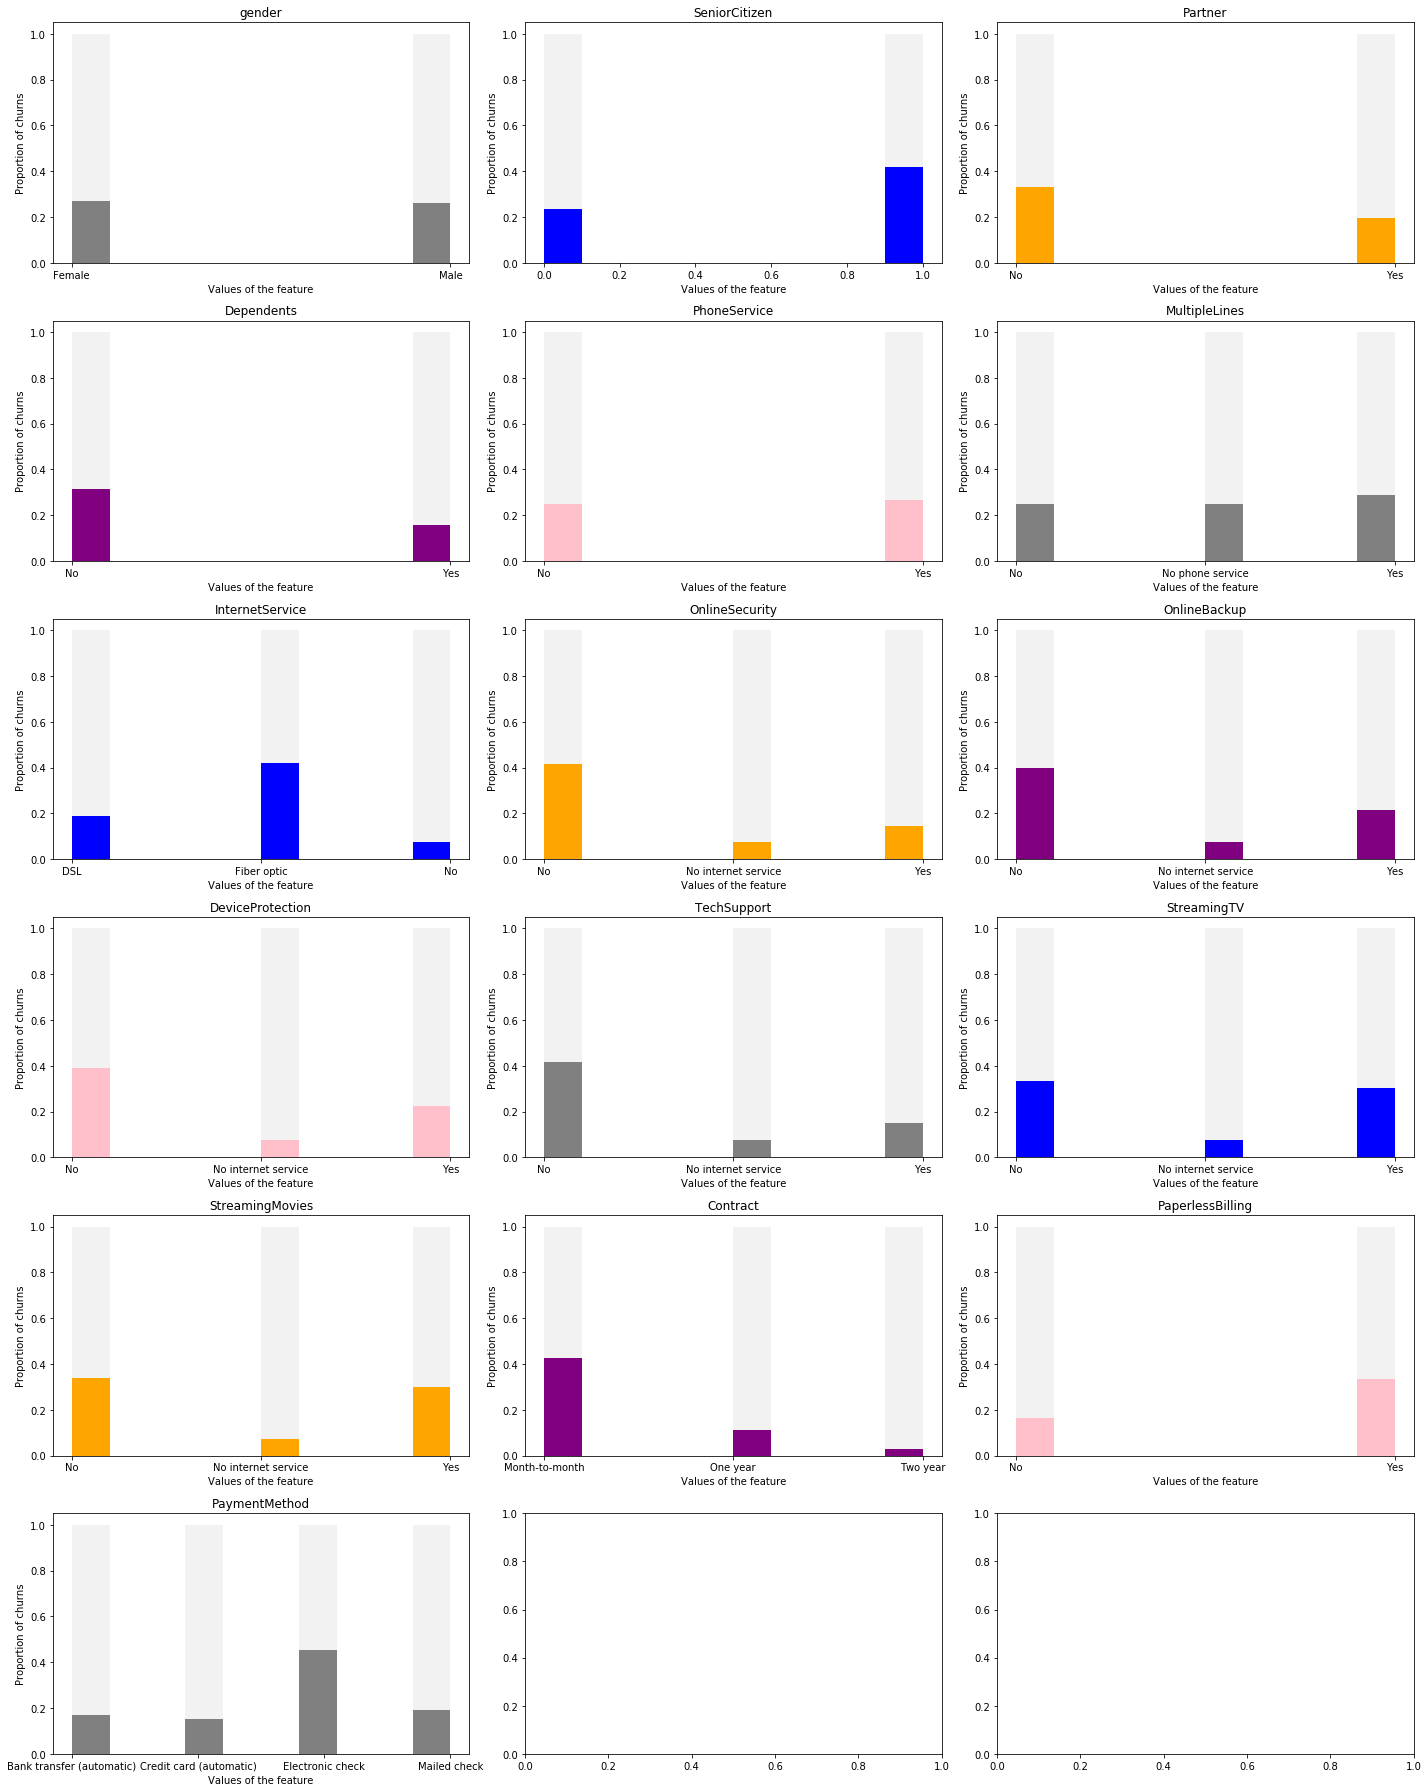

In [13]:
print("Proportion of churns for each feature: (the light gray aera is the proportion of people who didn't churn)")

columns = churn_original.drop("tenure", axis=1).columns[1:-3]
churned = churn_original[churn_original.Churn == "Yes"]

color = ["grey", "blue", "orange", "purple", "pink"]

fig, ax = plt.subplots(6, 3, figsize=(20,25))

for i in range(len(columns)):
    column_name = str(columns[i])
    
    weights = np.ones(churned.shape[0])
    weights1 = np.ones(churned.shape[0])

    for value in churned[column_name].value_counts().index.values.tolist():
        weights[churned[column_name] == value] = 1/churn_original[column_name].value_counts().loc[value]
        weights1[churned[column_name] == value] = 1/churned[column_name].value_counts().loc[value]
        
    ax[int(i/3)][i%3].hist(churned[column_name], color="#f2f2f2", weights=weights1)    
    ax[int(i/3)][i%3].hist(churned[column_name], color=color[i%5], weights=weights)
                          
    ax[int(i/3)][i%3].set_title(column_name)
    ax[int(i/3)][i%3].set_xlabel("Values of the feature")
    ax[int(i/3)][i%3].set_ylabel("Proportion of churns")
    
plt.tight_layout()


*We observe a lot of things with this first analysis.<br>
First, some features to have very little influence on the churn, such as the gender, the multiple lines, the phone service.
Other features seem to be very important, like the tech support, the online security, the contract.<br><br>
3 payment methods look similar but the electronic check however leads to much more churns than the others.*

### Analysis of the tenure

In [14]:
tenure = churn_original[["tenure","Churn"]].copy()

In [15]:
tenure['tenure6'] = pd.Series(tenure.tenure <= 6, tenure.index)
tenure['tenure6_20'] = pd.Series(np.logical_and(tenure.tenure > 6, tenure.tenure <= 20), tenure.index)
tenure['tenure20_40'] = pd.Series(np.logical_and(tenure.tenure > 20, tenure.tenure <= 40), tenure.index)
tenure['tenure40_60'] = pd.Series(np.logical_and(tenure.tenure > 40, tenure.tenure <= 60), tenure.index)
tenure['tenure60'] = pd.Series(tenure.tenure > 60, tenure.index)
tenure['tenure_step'] = tenure['tenure6'] + 2 * tenure['tenure6_20'] + 3 * tenure['tenure20_40'] + 4 * tenure['tenure40_60'] + 5 * tenure['tenure60']
tenure_step_churn = np.array(tenure[tenure.Churn == 'Yes'].tenure_step)
tenure_step_not_churn = np.array(tenure[tenure.Churn == 'No'].tenure_step)
churn_graph = [tenure_step_churn, tenure_step_not_churn]

Text(0,0.5,'Number of clients')

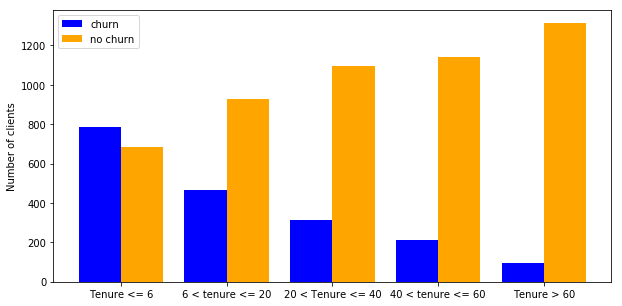

In [16]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

colors = ['blue', 'orange']

ax.hist(churn_graph, 5, histtype='bar', label=["churn", "no churn"],  color=colors)
ax.legend()
ax.set_xticks([1.4,2.2,3,3.8,4.6])
ax.set_xticklabels(["Tenure <= 6","6 < tenure <= 20","20 < Tenure <= 40","40 < tenure <= 60","Tenure > 60"])
ax.set_ylabel("Number of clients")

*We observe that people who are clients since a long time are less likely to churn.*

# Machine learning

Now, further analysis...

In [17]:
#function taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest')#, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [18]:
def build_confusion_matrix(labels, prediction, show_graph, title='Confusion matrix'):
    cm = confusion_matrix(labels, prediction)
    (tn, fp, fn, tp) = cm.ravel()
    if show_graph == True:
        plt.figure()
        print(cm)
        plot_confusion_matrix(cm, ["No Churn", "Churn"], normalize=False, title=title)
    return cm.ravel()

In [19]:
train = churn.iloc[0:6000].drop("customerID", axis=1)
test =  churn.iloc[6001:7000].drop("customerID", axis=1)

In [20]:
def predict_random_forest(train, test):
    classifier = RandomForestClassifier()
    classifier.fit(train.drop("Churn", axis=1), train.Churn)
    predicted_churn = classifier.predict(test.drop("Churn", axis=1))
    classifier_score = classifier.score(test.drop("Churn", axis=1), test.Churn)
    cm = build_confusion_matrix(test.Churn, predicted_churn, True, title="Random Forest")
    return (classifier_score, classifier.predict)

In [21]:
def random_forest_proba_classifier(x, classifier, split_value):
    prediction = classifier.predict_proba(x)
    prediction[prediction <= split_value] = 0
    prediction[prediction > split_value] = 1
    return prediction

def predict_random_forest_proba(train, test):
    classifier = RandomForestClassifier()
    classifier.fit(train.drop("Churn", axis=1), train.Churn)
    predicted_churn = classifier.predict_proba(test.drop("Churn", axis=1))
    prediction = predicted_churn.T[1].T
    c = cl.Counter(prediction)
    a = sorted(list(c.items()))
    keys = np.array(a).T[0].T
    values = np.array(a).T[1].T
    proportion = churn.Churn.value_counts()

    counter = 0
    index=0
    while counter < (proportion[1] * sum(values) / (proportion [0] + proportion[1])):
        index += 1
        counter += values[index]
    prediction[prediction <= keys[index]] = 0
    prediction[prediction > keys[index]] = 1
    matched = (prediction - np.array(test.Churn) == 0)
    score = (prediction - np.array(test.Churn) == 0).sum()/len(test)
    cm = build_confusion_matrix(test.Churn, prediction, True, title="Random Forest with Probabilities")
    return (score, cm, partial(random_forest_proba_classifier, classifier=classifier, split_value=keys[index]))

In [22]:
def predict_log_reg(train, test):
    X_train = train.drop("Churn", axis=1)
    X_test = test.drop("Churn", axis=1)
    y_train = train.Churn
    y_test = test.Churn
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train,y_train)
    pred = logisticRegr.predict(X_test)
    score = accuracy_score(y_test, pred)
    cm = build_confusion_matrix(y_test, pred, True, title="Logistic regression")
    return (score, cm, logisticRegr.predict)

[[588  67]
 [124 100]]


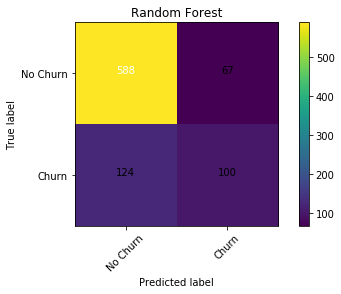

[[512 143]
 [ 75 149]]


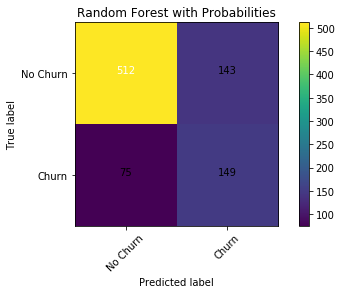

[[586  69]
 [106 118]]


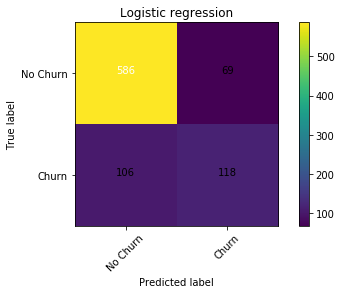

[[586  57]
 [128 108]]


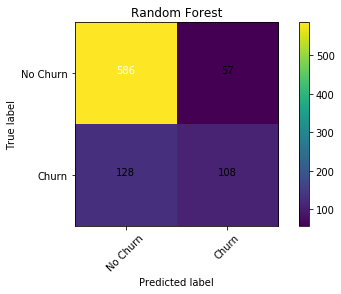

[[472 171]
 [ 52 184]]


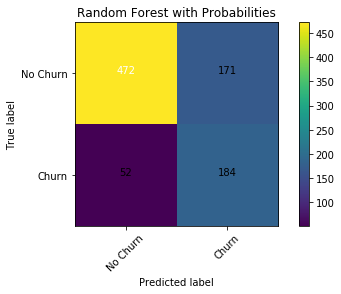

[[579  64]
 [ 98 138]]


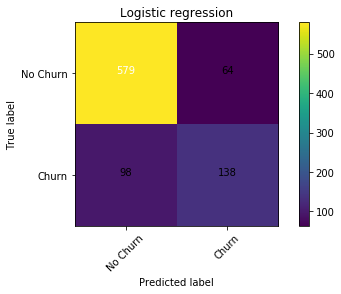

[[576  75]
 [124 104]]


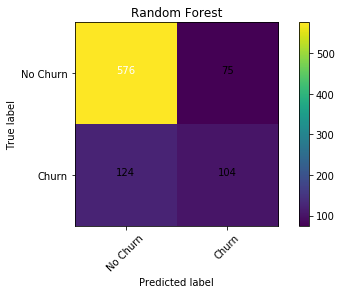

[[523 128]
 [ 78 150]]


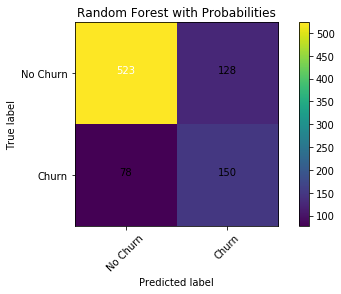

[[574  77]
 [102 126]]


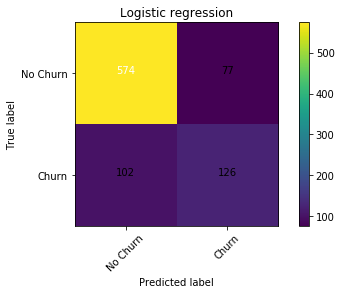

[[586  64]
 [137  92]]


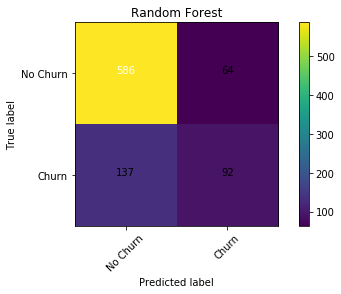

[[517 133]
 [ 76 153]]


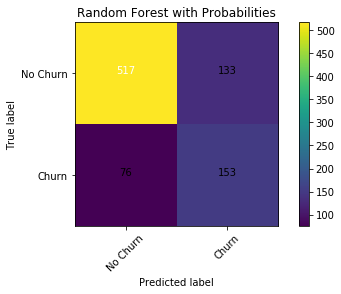

[[582  68]
 [104 125]]


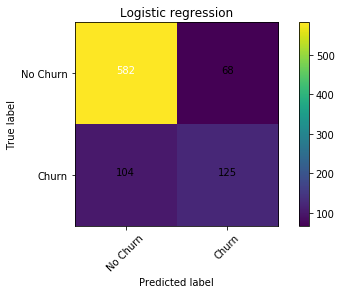

[[565  79]
 [143  92]]


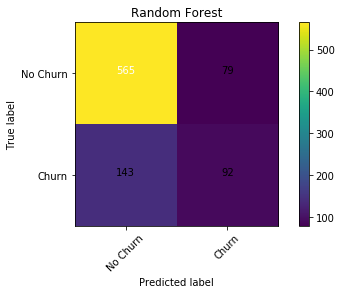

[[493 151]
 [ 88 147]]


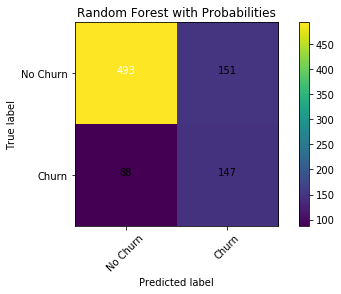

[[576  68]
 [110 125]]


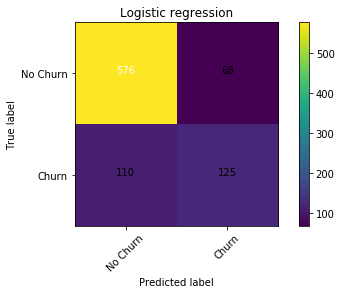

[[577  71]
 [123 108]]


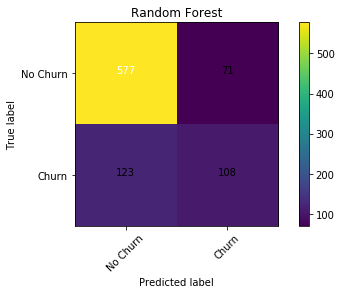

[[498 150]
 [ 82 149]]


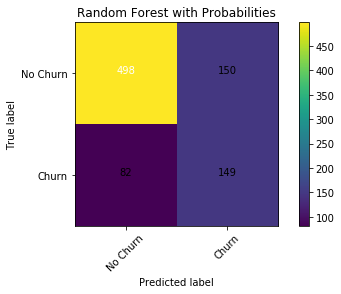

[[573  75]
 [ 95 136]]


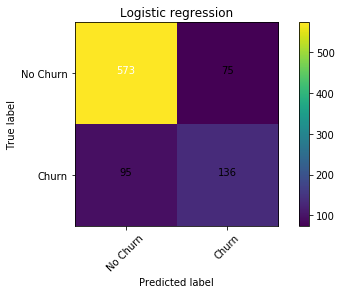

[[580  56]
 [135 108]]


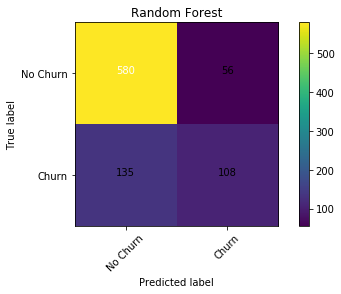

[[524 112]
 [ 90 153]]


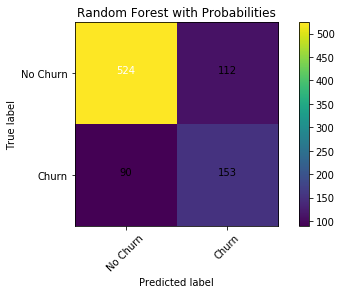

[[577  59]
 [112 131]]


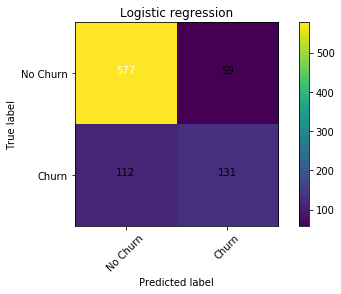

[[581  55]
 [126 117]]


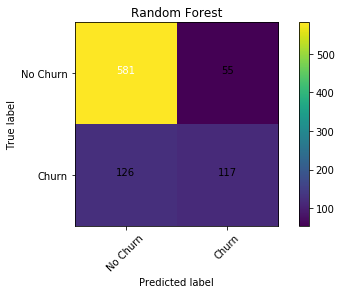

[[506 130]
 [ 90 153]]


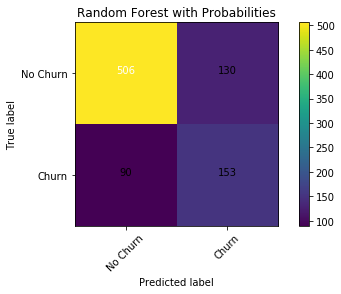

[[578  58]
 [114 129]]


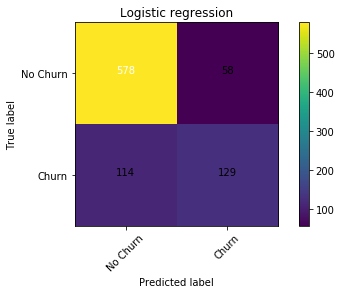

(0.7775881683731514, 0.7512798634812287, 0.8038964732650741)

In [23]:
def mean_score(x):
    return np.array(x).T[0].sum() / len(x)

churn.sample(frac=1)
n = 8
chunk_size = int(len(churn) / n)
random_forest = []
random_forest_proba = [] 
log_reg = []
for i in range(n):
    test_low = i * chunk_size
    test_high = (i + 1) * chunk_size
    train_index = list(range(len(churn)))
    for j in range(test_low, test_high):
        train_index.remove(j)
    train = churn.iloc[train_index].drop("customerID", axis=1)
    test = churn.iloc[test_low:test_high].drop("customerID", axis=1)
    random_forest.append(predict_random_forest(train, test))
    random_forest_proba.append(predict_random_forest_proba(train, test))
    log_reg.append(predict_log_reg(train, test))
(mean_score(random_forest), mean_score(random_forest_proba), mean_score(log_reg))